# University Of London
## ST2195 Coursework
### ROY LEE JING YI     200615938

Importing libraries for our session

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer #transform different types
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

### Preparing our data

Once we've downloaded the necesary data files from Harvard Dataverse at https://doi.org/10.7910/DVN/HG7NV7.
We can being to read the csv files into dataframe and make some tweaks.

The following files will be used:
1. 2006.csv, 2007.csv
2. airports.csv, carriers.csv, plane-data.csv

In [5]:
# Set wd using os on macbook
os.chdir('/users/roylee/OneDrive/SIM Year 2/ST2195 Programming to Data Science/Coursework_st2195')
# Set wd using os on windows
#os.chdir('D:/OneDrive/SIM Year 2/ST2195 Programming to Data Science/Coursework_st2195')

# Ignore warnings
warnings. filterwarnings('ignore')

# set chart style for plots using seaborn
sns.set_style("darkgrid")
plt.style.use('seaborn-darkgrid')
# set plot size
sns.set(rc = {'figure.figsize':(12,8)})
plt.rcParams['figure.figsize']=[12,8]
plt.rcParams['figure.dpi']= 100

# Set columns that we will be using
impt_cols = ['Year','Month','DayofMonth','DayOfWeek', 'Distance',
            'DepTime','ArrTime','UniqueCarrier','TailNum', 'FlightNum',
            'ArrDelay','DepDelay','Origin','Dest','Cancelled']

# Use pandas:pd.read_csv to read the csv files into dataframes(df) and only extracting 'impt_cols' columns
df_2006 = pd.read_csv('2006.csv', usecols=impt_cols)
df_2007 = pd.read_csv('2007.csv', usecols=impt_cols)

# Use pandas:pd.concat to combine both dataframes into df_flights
df_flights = pd.concat([df_2006,df_2007], ignore_index=True)

# Read the rest of the csv files
df_airport = pd.read_csv('airports.csv')
df_carrier = pd.read_csv('carriers.csv')
df_planes = pd.read_csv('plane-data.csv')

# Drop all NA values from following columns to remove cancelled flights
df_flights = df_flights.dropna(subset=['DepTime','ArrTime','ArrDelay','DepDelay','TailNum'])
df_flights.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled
0,2006,1,11,3,743.0,1024.0,US,343,N657AW,6.0,-2.0,ATL,PHX,1587,0
1,2006,1,11,3,1053.0,1313.0,US,613,N834AW,-5.0,0.0,ATL,PHX,1587,0
2,2006,1,11,3,1915.0,2110.0,US,617,N605AW,-23.0,0.0,ATL,PHX,1587,0
3,2006,1,11,3,1753.0,1925.0,US,300,N312AW,-8.0,-2.0,AUS,PHX,872,0
4,2006,1,11,3,824.0,1015.0,US,765,N309AW,0.0,-8.0,AUS,PHX,872,0


Next we clean up the dataframes for easier analysis and plotting

In [6]:
# For Q3, Q4 - create new column 'Date' by combining columns and converting to datetime format YYYY/MM/DD
df_flights['Date'] = df_flights[['Year','Month','DayofMonth']].apply(lambda x:'/'.join(x.values.astype(str)), axis="columns")
df_flights['Date'] = pd.to_datetime(df_flights['Date'], format="%Y/%m/%d")

# For Q2, Q5 - remove rows from column 'year' where empty, 'None', '0' and is NULL
df_planes = df_planes.drop(df_planes[df_planes.year.isin(["None", "0000", ""])].index).dropna().reset_index(drop=True)
df_planes = df_planes.rename(columns= {'year':'PlaneYear'}) # rename 'year' to 'PlaneYear'
df_planes['PlaneYear'] = df_planes['PlaneYear'].astype(int) # convert str to int
df_planes.head()

# For Q4 - create function to convert DepTime and ArrTime:
# These two columns represent the time of day (24H) in str format. However, there are rows with values higher than 2359.
# Hence we will identify values higher and equal to 2400, and then convert it to 24H valyes
def convert_DepT(row):
   if row['DepTime'] >= 2400:
       x = row['DepTime'] - 2400
       return x
   else:
       return row['DepTime']
def convert_ArrT(row):
   if row['ArrTime'] >= 2400:
       x = row['ArrTime'] - 2400
       return x
   else:
       return row['ArrTime']
# we use .apply() to apply the convert_DepT and convert_ArrT to the proper columns
df_flights['DepTime'] = df_flights.apply(convert_DepT, axis=1)
df_flights["ArrTime"] = df_flights.apply(convert_ArrT, axis=1)
df_flights.head()

# !Export csv for R project so we don't need to do the same thing again
#df_flights.to_csv('flights.csv')
#df_planes.to_csv('n_plane-data.csv')

,Year,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,Date
0,2006,1,11,3,743.0,1024.0,US,343,N657AW,6.0,-2.0,ATL,PHX,1587,0,2006-01-11
1,2006,1,11,3,1053.0,1313.0,US,613,N834AW,-5.0,0.0,ATL,PHX,1587,0,2006-01-11
2,2006,1,11,3,1915.0,2110.0,US,617,N605AW,-23.0,0.0,ATL,PHX,1587,0,2006-01-11
3,2006,1,11,3,1753.0,1925.0,US,300,N312AW,-8.0,-2.0,AUS,PHX,872,0,2006-01-11
4,2006,1,11,3,824.0,1015.0,US,765,N309AW,0.0,-8.0,AUS,PHX,872,0,2006-01-11


### Q1. What is the best time of day, day of week, time of year to fly to minimise delays

### Best time of day to fly to minimise delays

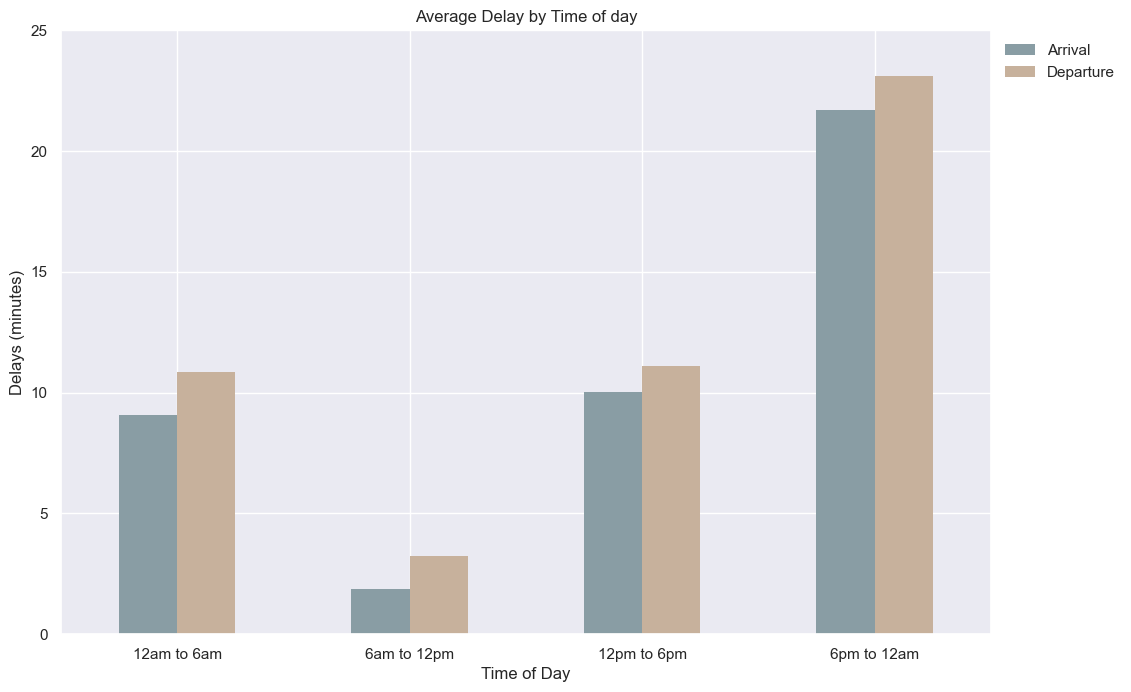

In [4]:
# select columns
q1_timeofday = df_flights[['DepTime','ArrDelay','DepDelay']]

# set new column for DepTime_range based on DepTime
period_labels = ["12am to 6am", "6am to 12pm", "12pm to 6pm", "6pm to 12am"]
period_bins = [0,600,1200,1800,2400] #set range of values
q1_timeofday['DepTime_range'] = pd.cut(q1_timeofday['DepTime'], bins=period_bins, labels=period_labels)

## Best time of day (tod)
q1_timeofday = q1_timeofday.filter(['DepTime_range','DepDelay','ArrDelay'])
q1_timeofday = q1_timeofday.groupby('DepTime_range')['ArrDelay','DepDelay'].mean()
#q1_timeofday.head()  #check

# Plot graph
ax = q1_timeofday[['ArrDelay','DepDelay']].plot.bar(rot=0, color=('#899DA4', '#C7B19C'), edgecolor="None") 
ax.set_ylim(top = 25) # make ylim max to be larger so that the legend and the bars are not overlapping

ax.set_ylabel('Delays (minutes)')
ax.set_xlabel('Time of Day')
ax.set_title('Average Delay by Time of day')
ax.legend(labels=['Arrival','Departure'], loc=2, bbox_to_anchor=(1, 1))

plt.show()


From this graph, we can observe that flights between 6am to 12pm has the lowest average in both arrival delays and departure delays. 

We can confidently conclude that Saturday is the best time of day to fly to minimize delays.

### Best time of the week to fly to minimize delay

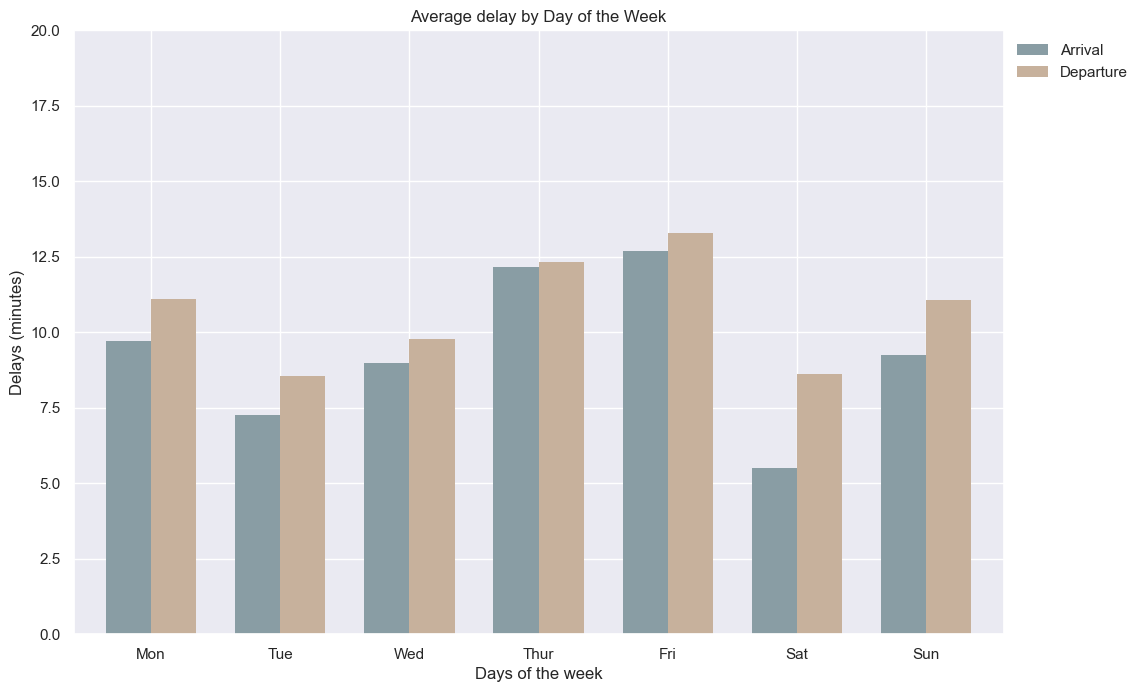

In [5]:
# Filter columns into new dataframe
q1_dayofweek = df_flights[['DayOfWeek','ArrDelay','DepDelay']]

# rename values in DayOfWeek dataframe from int values to str values
c_DayOfWeek = {1:"Mon", 2:"Tue", 3:"Wed", 4:"Thur", 5:"Fri", 6:"Sat", 7:"Sun"}
q1_dayofweek['DayOfWeek'] = q1_dayofweek['DayOfWeek'].astype('category').apply(lambda x:c_DayOfWeek[x])

q1_dayofweek = q1_dayofweek.groupby('DayOfWeek')['ArrDelay','DepDelay'].mean()
#q1_dayofweek.head()  #check

ax = q1_dayofweek[['ArrDelay','DepDelay']].plot.bar(rot=0, color=('#899DA4', '#C7B19C'), edgecolor="None", width = 0.7) 

ax.set_ylim(top = 20) # make ylim max to be larger so that the legend and the bars are not overlapping

ax.set_ylabel('Delays (minutes)')
ax.set_xlabel('Days of the week')
ax.set_title('Average delay by Day of the Week')
ax.legend(labels=['Arrival','Departure'], loc=2, bbox_to_anchor=(1, 1))

plt.show()

From this graph, we can observe that flights on Saturday has the lowest average in arrival delays while Tuesdays have the lowest average in departure delays.

We can conclude that Saturday is the best time of week to fly to minimize delays as you are more likely to arrive early at your destination even though the flight departs late

### Best time of year to fly to minimise delays

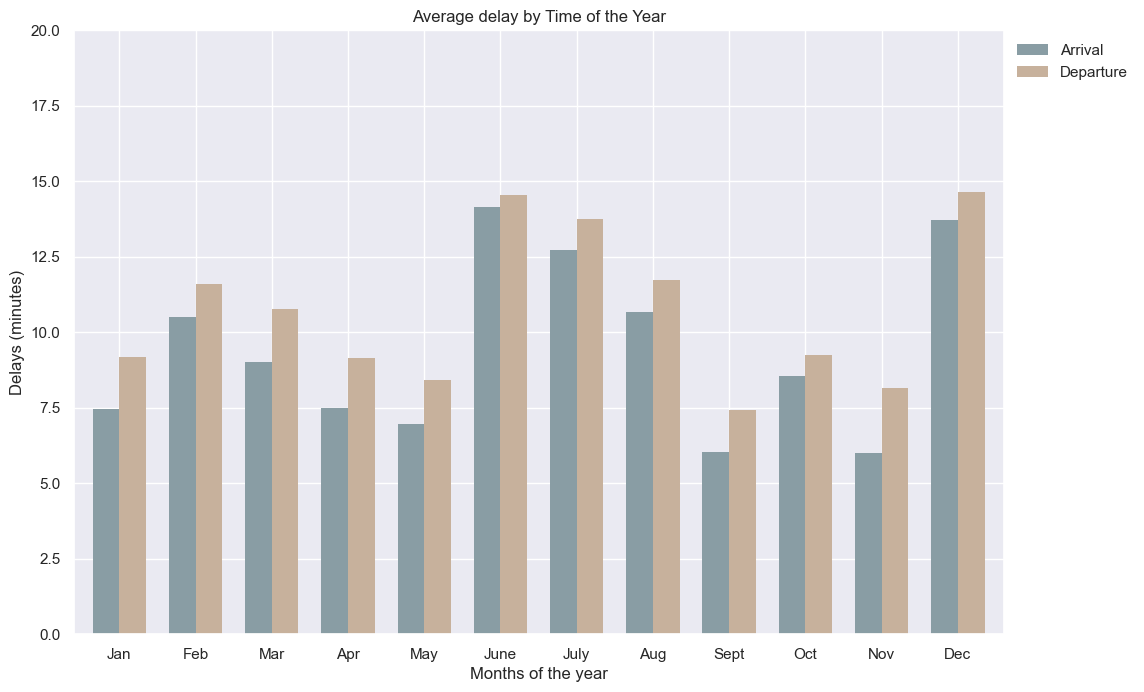

In [6]:
# Filter columns into new dataframe
q1_timeofyear = df_flights[['Month','ArrDelay','DepDelay']]
c_Month ={1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"June",
          7:"July", 8:"Aug", 9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec"}
q1_timeofyear['Month'] = q1_timeofyear['Month'].astype('category').apply(lambda x:c_Month[x])


# Group data by Month and get the mean of ArrDelay & DepDelay
q1_timeofyear = q1_timeofyear.groupby('Month')['ArrDelay','DepDelay'].mean()
#q1_timeofyear.head()  #check

ax = q1_timeofyear[['ArrDelay','DepDelay']].plot.bar(rot=0, color=('#899DA4', '#C7B19C'),
                                                     edgecolor="None", width = 0.7) 

ax.set_ylim(top = 20) 
ax.set_ylabel('Delays (minutes)')
ax.set_xlabel('Months of the year')
ax.set_title('Average delay by Time of the Year')
ax.legend(labels=['Arrival','Departure'], loc=2, bbox_to_anchor=(1, 1))

plt.show()

From this graph, we can observe that flights in June, July, August and December have the highest average delay for arrivals and departures whereas flights from Jan to May and Sept to Nov have relatively lower delays.

We can conclude that the best time of the year to fly to minimize delay are in the months leading up to June, and especially in the last quarter in the months leading up to December.

### Q2. Do older panes suffer more delay?

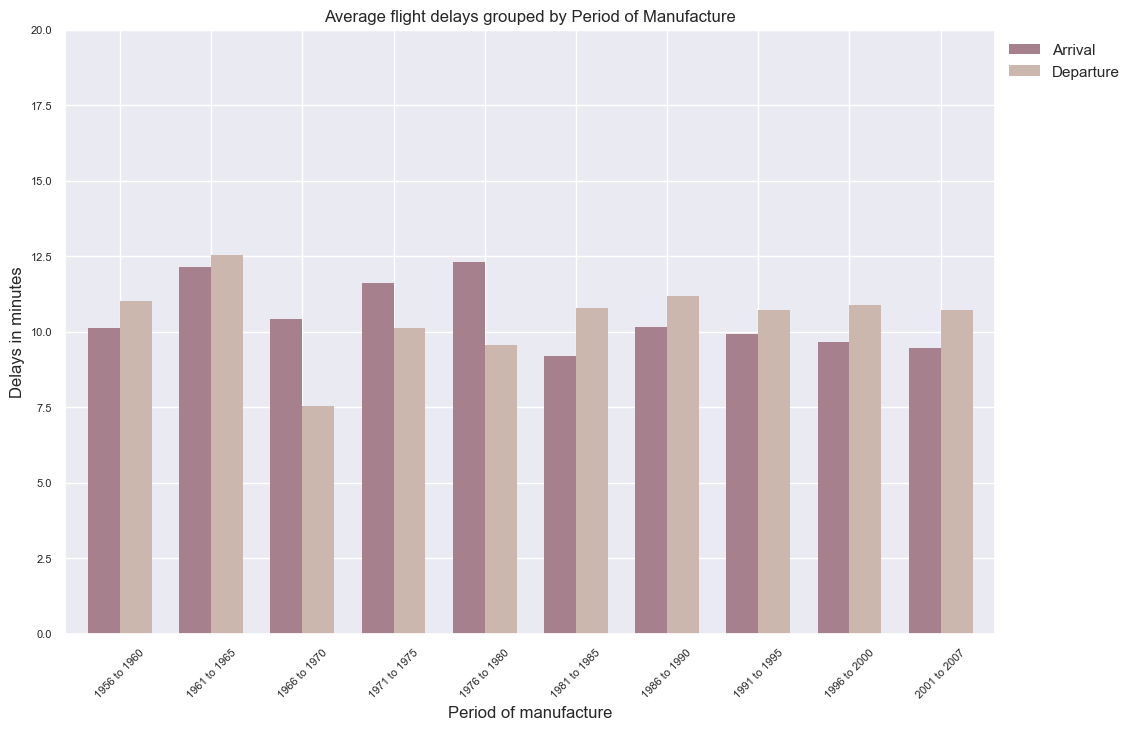

In [7]:
# Create new df_q2 -> merge df_flights with df_plane to get 'year' column for manufacture date
df_q2 = df_flights.merge(df_planes[['tailnum','PlaneYear']],how='left',left_on='TailNum',right_on='tailnum')
#df_q2.info()

#filter out year, arrdelay and depdelay
df_q2 = df_q2.filter(['PlaneYear', 'ArrDelay', 'DepDelay'])

# cut data into categories
oldvnew_labels = ["1956 to 1960", "1961 to 1965", "1966 to 1970", "1971 to 1975",
                  "1976 to 1980","1981 to 1985", "1986 to 1990", "1991 to 1995", 
                  "1996 to 2000", "2001 to 2007"] # set labels
oldvnew_bins = [1955, 1960, 1965, 1970, 1975, 
                1980, 1985, 1990, 1995, 2000, 2007]  #set range of bin
df_q2['PlanePeriod'] = pd.cut(df_q2['PlaneYear'], bins=oldvnew_bins, labels=oldvnew_labels)
#df_q2.info()  #check

# prepare df for plotting
df_q2 = df_q2.groupby('PlanePeriod')[['ArrDelay','DepDelay']].mean()

# plot df onto matplotlib
ax = df_q2[['ArrDelay','DepDelay']].plot.bar(rot=0, width = 0.7,
                                                  color=("#a6808c","#ccb7ae"), edgecolor="None") 
ax.set_ylim(top = 20) 
ax.set_ylabel('Delays in minutes')
ax.set_xlabel('Period of manufacture')
ax.set_title('Average flight delays grouped by Period of Manufacture')
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(labels=['Arrival','Departure'], loc=2, bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

From this graph, there is no significant difference in the average delays of flights between planes manufactured in different periods. Nor is there an distinct pattern when comparing older and newer planes. Although planes manufactured from 1956 to 1960 have the longest average delay, planes manufactured from 1961 to 1965 actually have considerably shorter delays.

After this time period however, we see a stagnation in the average of flight delays instead of a drop indicating that newer planes are no better than older planes. Hence it is there is no substantial evidence to conclude if older planes suffer more delays. 

### Q3. How does the number of people flying across locations change over time

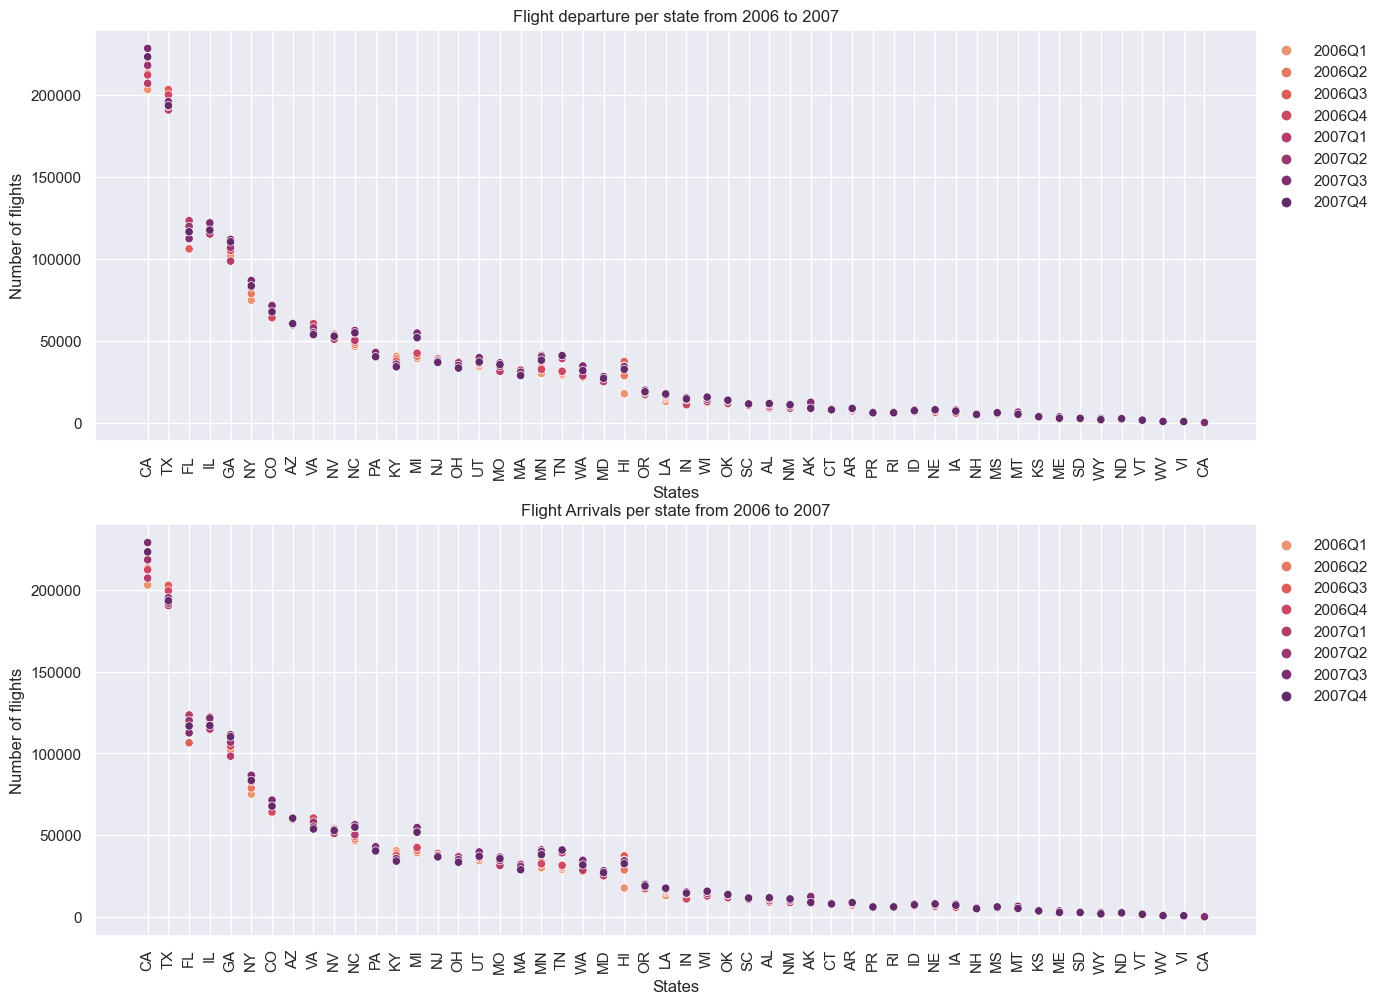

In [8]:
# Merge df_delay with df_airport to get 'airport' column
df_q3 = df_flights.merge(df_airport[['iata','airport','state']], how='left',left_on='Origin',right_on='iata')
df_q3 = df_q3.merge(df_airport[['iata','airport','state']], how='left',left_on='Dest',right_on='iata')
df_q3 = df_q3.rename(columns= {'airport_x':'DepAirport', 'state_x':'DepState',
                                         'airport_y':'ArrAirport', 'state_y':'ArrState'})

# Filter Important columns
# convert Date to quarterly period
df_q3 = df_q3.filter(['Date','DepState', 'ArrState'])
df_q3['Date'] = df_q3['Date'].dt.to_period('Q')
#df_q3.info()

# 1. flights_out to filter out flights that departed state,
# 2. Group flights by Year/Month and count state to get no. of flights
flights_out = df_q3.filter(['Date','DepState'])
flights_out = flights_out["DepState"].groupby(flights_out["Date"]).value_counts().rename("DepCount").reset_index()
#flights_out.info() #check

# 1. flights_in to filter out flights that arrive state,
# 2. Group flights by Year/Month and count state to get no. of flights
flights_in = df_q3.filter(['Date','ArrState'])
flights_in = flights_in["ArrState"].groupby(flights_in["Date"]).value_counts().rename("ArrCount").reset_index()
#flights_in.head() #check

# Plot graph
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# # ==== Graph 1 - Departure ====
sns.scatterplot(x = 'DepState', y = 'DepCount', 
                palette="flare", hue = "Date",
                data = flights_out, ax=ax[0])

ax[0].set(xlabel = 'States', ylabel= 'Number of flights', title = 'Flight departure per state from 2006 to 2007' )
ax[0].set_xticklabels(flights_out['DepState'], rotation = 90)
ax[0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5, facecolor='white', edgecolor='white')


# # ==== Graph 2 - Arrival ====
sns.scatterplot(x = 'ArrState', y = 'ArrCount', 
                palette="flare", hue = "Date",
                data = flights_in, ax=ax[1])

ax[1].set(xlabel = 'States', ylabel='Number of flights', title = 'Flight Arrivals per state from 2006 to 2007')
ax[1].set_xticklabels(flights_in['ArrState'], rotation = 90)
ax[1].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5, facecolor='white', edgecolor='white')
plt.show()

From both graphs we can observe that California(CA), Texas(TX), Illinois(IL), and Georgia(GA) ranks the highest in terms of outgoing and incoming flights between 2006 and 2007.

We can notice a growing trend for US states with substantial outgoing and incoming flights, where the '2007 Q4' plot is higher than the earlier quarters plot. This indicates that the number of people flying in and out of popular states have increased from 2006 to 2007.

However states with a much lower flight count from 2006 to 2007 like the Virgin islands(VI) or Detroit (DE), has had minimal growth from 2006 to 2007.

### Q4. Can you detect cascading failures as delays in one airport create delays in another

To observe if cascading failure is present, we will use data from flights travelling between Los Angeles airport (LAX) and John F kennedy aiport (JFK), during within January 2007.

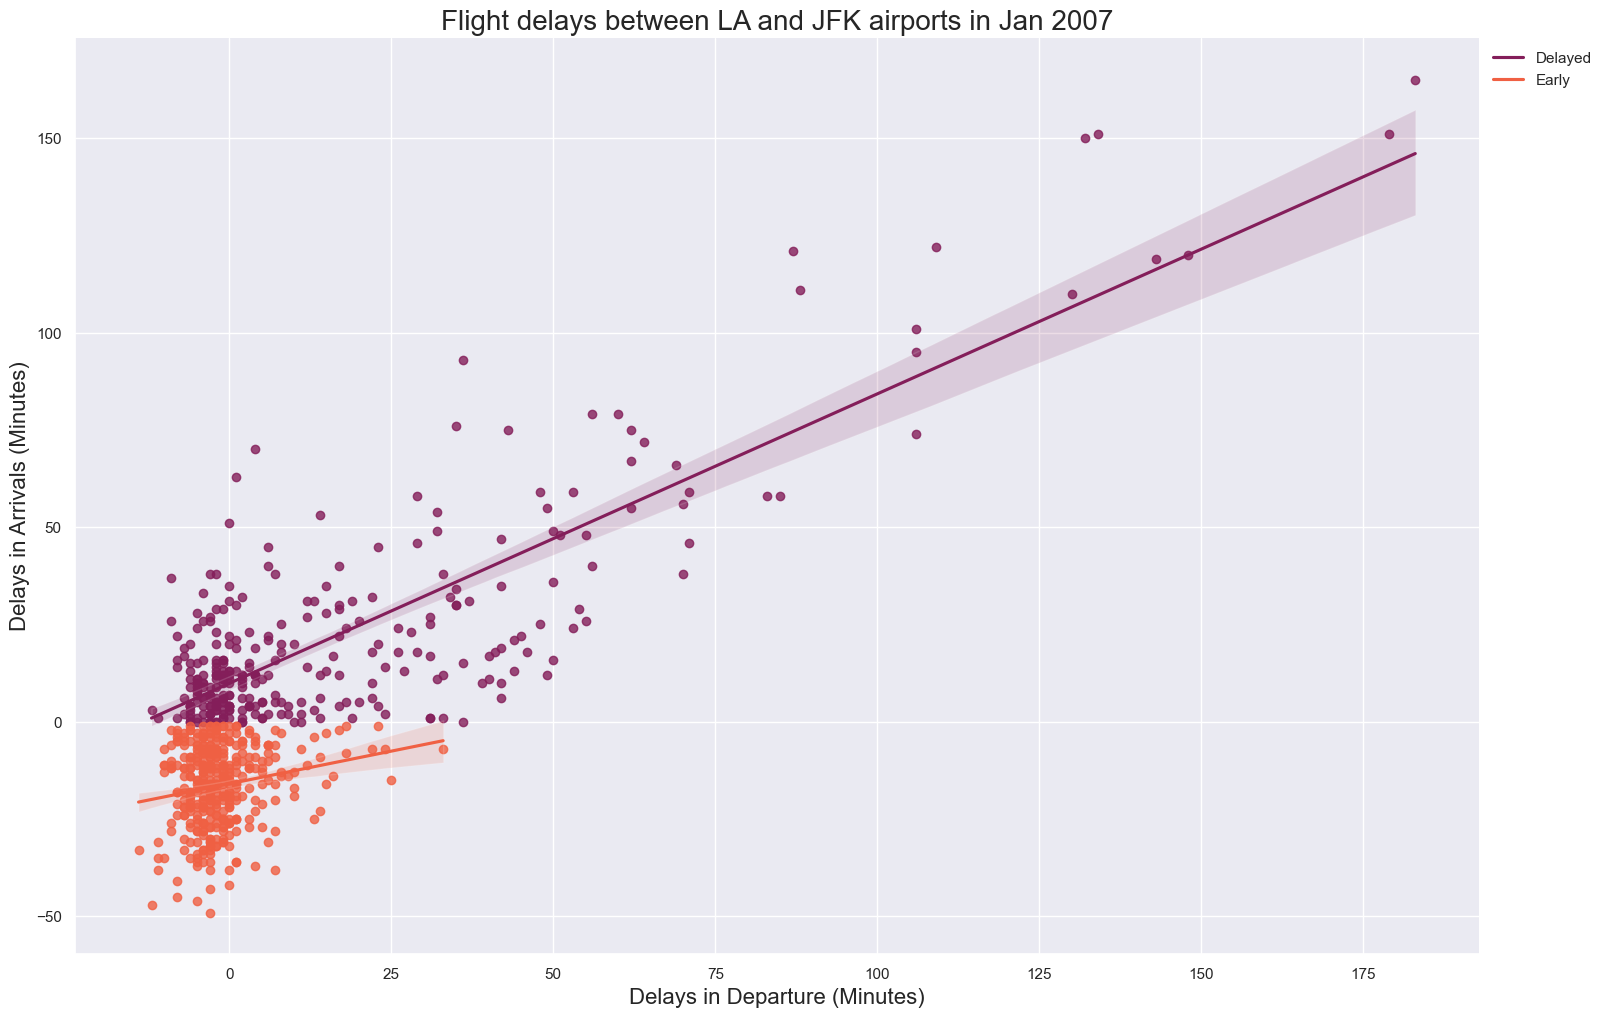

In [10]:
def flight_status(row):
   if row['ArrDelay'] < 0:
       return 'Early'
   else:
       return 'Delayed'

## Preparing the data
# 1. Merge df_airport and df_flights4
# 2. Filter out specific airport and specific day using LOC
df_q4 = pd.merge(df_flights, df_airport[['iata','airport']], 
                       how='inner', left_on='Origin',right_on='iata')
df_q4 = df_q4.loc[(df_q4['Year'] == 2007) & (df_q4['Month'] == 1) & 
                  (df_q4['Origin'] == 'LAX') & (df_q4['Dest'] == 'JFK')]

## Fine tune data
# 1. Filter out necessary columns
# 2. Create new columns for flight status
df_q4 = df_q4.filter(['DepDelay', 'ArrDelay'])
df_q4["ArrivalStatus"] = df_q4.apply(flight_status, axis=1)
#df_q4.head(50) #check


sns.lmplot(x='DepDelay', y='ArrDelay', data=df_q4,
           hue='ArrivalStatus', palette='rocket', legend=False, 
           height = 10, aspect = 1.5)
plt.xlabel('Delays in Departure (Minutes)', size=16)
plt.ylabel('Delays in Arrivals (Minutes)', size=16)
plt.title('Flight delays between LA and JFK airports in Jan 2007', size=20)
plt.legend(labels=['Delayed','Early'], loc=2, bbox_to_anchor=(1, 1))
plt.show()


From the graph, we can observe a positive correlation between between delays in departure and delays in arrivals regardless if the flight is early or late. Hence we can confidently say that the likelihood of flights departing late also arriving late is quite high, and this delay will cascade by causing future flights to depart late.

### Q5. Use the available variables to construct a model that can predict delays

We will utilize the following columns from df_flights and df_planes:
'DayOfWeek','Month','DayofMonth','DepTime','DepDelay','Distance' and 'PlaneYear' to build our prediction model

In [7]:
def delay_status(row):
   if row['ArrDelay'] > 0 :
       return 1
   else:
       return 0

# Merge df_flights and df_planes, create column for X and y sets
cols_ml = ['DayOfWeek','Month','DayofMonth','DepDelay','DepTime','Distance','PlaneYear']

q5_ml = df_flights.merge(df_planes[['PlaneYear', 'tailnum']], how = 'left',
                left_on = 'TailNum', right_on = 'tailnum').drop(columns = ['tailnum'])
q5_ml = q5_ml.loc[q5_ml['ArrDelay'] < 600] # remove outliers to avoid skewing results
q5_ml = q5_ml[q5_ml['PlaneYear'].notna()].sample(n=100000) # retrieve randomized non-na columns 

# Create new column for ArrDelay status
q5_ml["ArrStatus"] = q5_ml.apply(delay_status, axis=1)
q5_ml[['ArrDelay','ArrStatus']].head() # check if DelayStatus column is accurate
q5_ml.isnull().sum() #check null values

# Create X set and y set
X = q5_ml[cols_ml].copy()
y = q5_ml[['ArrStatus']].copy() # for logistic regression, gradient boosting
y2 = q5_ml[['ArrDelay']].copy() # for linear regression, random forest

# Numeric
numerical_features = ['DayOfWeek','Month','DayofMonth',
                      'DepDelay','DepTime','Distance','PlaneYear']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

# Data transformer
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features)])

# Set parameters
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean','median','most_frequent']
    }

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=1)

### Logistic Regression & Gradient Boosting

In [15]:
# ==================   Logistic Regression   =====================
pipe_log = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_lr', LogisticRegression(max_iter=10000, penalty='none'))])
grid_log = GridSearchCV(pipe_log, param_grid=param_grid)
grid_log.fit(X_train, y_train.values.ravel());  # train the model against training data
grid_log.score(X_test, y_test) # test the model against testing data

# calculate additional values
y_pred_log = grid_log.predict(X_test)
RMSE_log= np.sqrt(mean_squared_error(y_test, y_pred_log))
MSE_log= mean_squared_error(y_test, y_pred_log)
MAE_log= mean_absolute_error(y_test, y_pred_log)

# ====================    Gradient Boosting    ========================
pipe_gb = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_gb',GradientBoostingClassifier(random_state=2))])
grid_gb = GridSearchCV(pipe_gb, param_grid=param_grid) # apply pipeline to parameters
grid_gb.fit(X_train, y_train.values.ravel()); # train the model against training data
grid_gb.score(X_test, y_test) # test the model against testing data

# calculate RMSE, MSE and MAE to show efficiency of model
y_pred_gb = grid_gb.predict(X_test)
RMSE_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
MSE_gb = mean_squared_error(y_test, y_pred_gb)
MAE_gb= mean_absolute_error(y_test, y_pred_gb)

#  Gradient boosting vs Logistic regression
print("Results for Logistic Regression")
print('Accuracy score =', grid_log.score(X_test, y_test))
print('RMSE =', RMSE_log)
print('MSE =', MSE_log)
print('MAE =', MAE_log)
print()
print("Results for Gradient Boosting")
print('Accuracy score =', grid_gb.score(X_test, y_test))
print('RMSE =', RMSE_gb)
print('MSE =', MSE_gb)
print('MAE =', MAE_gb)

Results for Logistic Regression
Accuracy score = 0.78475
RMSE = 0.4639504283864818
MSE = 0.21525
MAE = 0.21525

Results for Gradient Boosting
Accuracy score = 0.7861
RMSE = 0.4624932431938871
MSE = 0.2139
MAE = 0.2139


The results for the Logistic Regression model and the Gradient Boosting model shows how minimal a difference there is between both models.
Both models have a 78% accuracy in predicting the delay of flights and all measurements are near identical. Hence either models could be used interchangeably as a prediction model.

### Linear Regression & Random Forest Regression 

In [8]:
# Linear Regression  ===========================================================
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_linear', LinearRegression())])
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid) #default cv is 5-fold

grid_lr.fit(X_train, y2_train.values.ravel());
grid_lr.score(X_test, y2_test)

# calculate additional values
y_pred_lr = grid_lr.predict(X_test)
RMSE_lr= np.sqrt(mean_squared_error(y2_test, y_pred_lr))
MSE_lr= mean_squared_error(y2_test, y_pred_lr)
MAE_lr= mean_absolute_error(y_test, y_pred_lr)

# Random Forest Regression  ====================================================
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
                          ('pipe_rf', RandomForestRegressor(random_state=0))])
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid)

grid_rf.fit(X_train, y2_train.values.ravel());
grid_rf.score(X_test, y2_test)

# calculate additional values
y_pred_rf = grid_rf.predict(X_test)
RMSE_rf= np.sqrt(mean_squared_error(y2_test, y_pred_rf))
MSE_rf= mean_squared_error(y2_test, y_pred_rf)
MAE_rf= mean_absolute_error(y_test, y_pred_rf)


# Difference between Linear Regression and Random Forest regression
print("Results for Linear Regression")
print('Result =', grid_lr.score(X_test, y2_test))
print('RMSE =', RMSE_lr)
print('MSE =', MSE_lr)
print('MAE =', MAE_lr)

print()
print("Results for Random Forest Regression")
print('Result =', grid_rf.score(X_test, y2_test))
print('RMSE =', RMSE_rf)
print('MSE =', MSE_rf)
print('MAE =', MAE_rf)

Results for Linear Regression
Result = 0.8466691198984112
RMSE = 14.173400566483657
MSE = 200.88528361799928
MAE = 15.496049100036258

Results for Random Forest Regression
Result = 0.8390957311925805
RMSE = 14.519211448759037
MSE = 210.8075010937755
MAE = 16.13862802380952


Both the Linear Regression model and Random Forest Regression model achieved an accuracy score of 85% and 83% respectively, proving to be more accurate than the Logistic regression and Gradient boosting model we constructed before.

However, Root Mean Squared Error(RMSE) and Mean Squared Error(MSE) for both the Linear Regression model and the Random Forest model is significantly higher as compared to the Logistic and Random Forest models which means that for failed predictions, the predicted values are much further than the result.

The Linear Regression model fares better in its Moving Average Error(MAE)score of 0.2185 against the Random Forest Regression model's score of 16.

Overall, if we choose to prioritise overall accuracy then the Linear Regression and Random Forest Regression models are the better choice for predicting flight delays. If we were to select models based on the variance in prediction then the Logistic Regression and Gradient Booster models are sufficient as well.